In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

In [2]:
train_set = datasets.FashionMNIST(root="",
                                 transform=transforms.ToTensor(),
                                 download = True,
                                 train = True)
test_set = datasets.FashionMNIST(root = "",
                                transform = transforms.ToTensor(),
                                train = False,
                                download = True)

In [3]:
print(len(train_set))
print(len(test_set))

60000
10000


In [4]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle =False)

In [5]:
for images , labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [6]:
train_set.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
def output_label(label):
    output_mapping = {
             0: "T-shirt/Top",
             1: "Trouser",
             2: "Pullover",
             3: "Dress",
             4: "Coat", 
             5: "Sandal", 
             6: "Shirt",
             7: "Sneaker",
             8: "Bag",
             9: "Ankle Boot"
    }
    input = (label.item() if type(label)== torch.Tensor else label)
    return output_mapping[input]

9


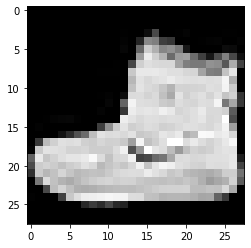

In [8]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

labels:  Pullover, Coat, T-shirt/Top, Sneaker, Pullover, Sneaker, T-shirt/Top, T-shirt/Top, Sandal, Ankle Boot, Dress, Dress, Ankle Boot, Coat, T-shirt/Top, Shirt, Trouser, T-shirt/Top, Sneaker, Shirt, Bag, Dress, Bag, Pullover, T-shirt/Top, Coat, Coat, Bag, Shirt, Trouser, Sneaker, Bag, Pullover, Sandal, Shirt, Sandal, Sneaker, Bag, Sneaker, Sandal, Dress, Ankle Boot, Trouser, Sandal, Trouser, Sneaker, Shirt, Sneaker, Bag, Pullover, T-shirt/Top, Pullover, Trouser, Coat, Bag, Coat, Pullover, Ankle Boot, Sandal, Shirt, Sneaker, Ankle Boot, Shirt, T-shirt/Top, 

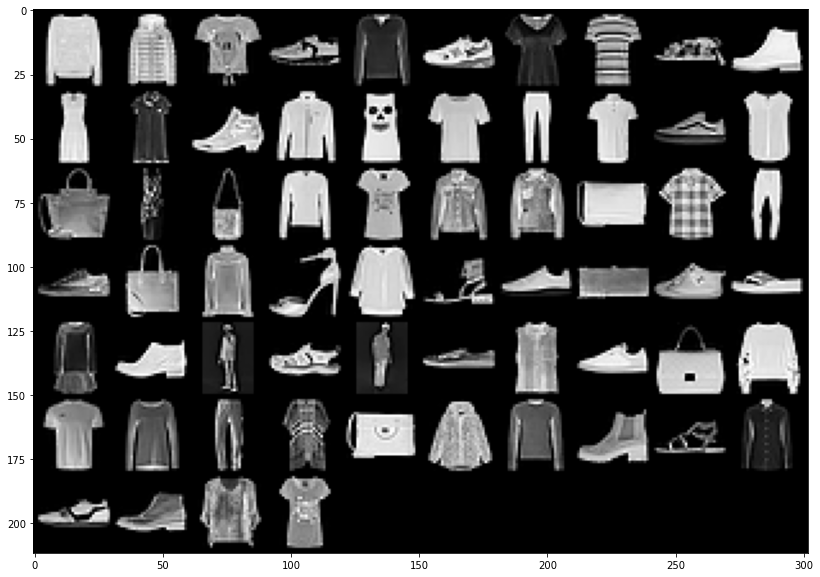

In [9]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3)
        # n-f+2p/s +1 = 28-3+1 = 26
        self.conv2 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=3)
        # 13-3+1 =11
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(5*5*32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.conv1(x) #26*26*16
        x = self.relu(x)
        x = self.pool(x) #13*13*16
        x = self.conv2(x) #11*11*32
        x = self.relu(x)
        x = self.pool(x) #5*5*32
        x = x.view(-1, 5*5*32)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [11]:
model = CNN()
print(model.parameters)

<bound method Module.parameters of CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)>


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [17]:
def CNN_train(loss_fn, optimizer):
    
    epochs = 20
    
    training_acc = []
    training_loss = []
    testing_acc = []
    testing_loss = []
    
    for epoch in range(epochs):

        train_acc = 0.0
        train_loss = 0.0
        
        model.train()

        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()

            predictions = torch.argmax(output, 1)

            train_acc += (predictions == labels).sum().item()
            train_loss += loss.item()

        training_acc.append(train_acc/len(train_set))
        training_loss.append(train_loss/len(train_loader))

        model.eval()

        test_acc = 0.0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                loss = loss_fn(output, labels)

                predictions = torch.argmax(output,1)

                test_acc += (predictions == labels).sum().item()
                test_loss += loss.item()

            testing_acc.append(test_acc/len(test_set))
            testing_loss.append(test_loss/len(test_loader))

            print("Epochs:{}, Training Accuracy:{:.2f}, Training Loss:{:.2f}, Testing Accuracy:{:.2f}, Testing Loss:{:.2f}".
                 format(epoch+1, train_acc/len(train_set)*100, train_loss/len(train_loader),
                        test_acc/len(test_set)*100, test_loss/len(test_loader)))

In [18]:
CNN_train(loss_fn, optimizer)

Epochs:1, Training Accuracy:90.95, Training Loss:0.24, Testing Accuracy:89.90, Testing Loss:0.28
Epochs:2, Training Accuracy:91.60, Training Loss:0.23, Testing Accuracy:90.08, Testing Loss:0.28
Epochs:3, Training Accuracy:92.09, Training Loss:0.21, Testing Accuracy:90.23, Testing Loss:0.28
Epochs:4, Training Accuracy:92.58, Training Loss:0.20, Testing Accuracy:89.92, Testing Loss:0.28
Epochs:5, Training Accuracy:93.03, Training Loss:0.19, Testing Accuracy:90.55, Testing Loss:0.26
Epochs:6, Training Accuracy:93.36, Training Loss:0.18, Testing Accuracy:90.92, Testing Loss:0.26
Epochs:7, Training Accuracy:93.76, Training Loss:0.17, Testing Accuracy:89.85, Testing Loss:0.29
Epochs:8, Training Accuracy:94.22, Training Loss:0.15, Testing Accuracy:91.04, Testing Loss:0.27
Epochs:9, Training Accuracy:94.53, Training Loss:0.15, Testing Accuracy:90.45, Testing Loss:0.28
Epochs:10, Training Accuracy:94.79, Training Loss:0.14, Testing Accuracy:90.86, Testing Loss:0.28
Epochs:11, Training Accuracy: